# <span style="color:slateblue"><b>Dependencies Import

In [ ]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import scipy.stats as sp
import itertools
from imblearn.ensemble import BalancedRandomForestClassifier

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import sklearn as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

from imblearn.metrics import classification_report_imbalanced

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# <span style="color:slateblue"><b>Data Load</span>

In [ ]:
userID='postgres'
password='toThaStars1!'
endpoint='kepler-exoplanet.cotbxoedtrfv.us-east-1.rds.amazonaws.com'
port='5432'
dbinstance='kepler-exoplanet'
dbinstance='kepler-damien'


db_string = f"postgres://{userID}:{password}@{endpoint}:{port}/{dbinstance}"
print(db_string)

engine = create_engine(db_string)
print(engine)

In [ ]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
# We can view all of the classes that automap found
Base.classes.keys()

In [ ]:
# Save references to each table
Raw_Data = Base.classes.raw_kepler

In [ ]:
# Reflect to see all the tables and respective columns
from sqlalchemy import inspect
inspector = inspect(engine)

for table_name in inspector.get_table_names():
   print("Table Name: %s" % table_name)
   for column in inspector.get_columns(table_name):
       print("Column: %s" % column['name'])

In [ ]:
# Reading the output from in tspect here is one table, load that table into a data frame. 
keplerRAW_df = pd.read_sql_table('raw_kepler', engine) 
keplerRAW_df

# <span style="color:slateblue"><b>CLEANING & EDA

In [ ]:
keplerRAW_df.info()

In [ ]:
keplerRAW_df.describe()

In [ ]:
# The default index adds no value, however the "kepoi_name" is the unique identified for each object of interest (row).
# We make this the index to preserve relationships through the processing

# change the index to the "kepoi_name" and drop the index title
keplerProcessed_df = keplerRAW_df.set_index('kepoi_name')
keplerProcessed_df.rename_axis(None, inplace=True)

keplerProcessed_df 

In [ ]:
# Find and drop err columns. These are +/- error ranges and are not needed for the models
columns_to_drop = [col for col in keplerProcessed_df.columns if '_err' in col]

keplerProcessed_df = keplerProcessed_df.drop(columns=columns_to_drop)
keplerProcessed_df

In [ ]:
# Rename columns to improve legibility
keplerProcessed_df.rename(columns={'kepid' : 'Kep_ID',
                               'kepoi_name' : 'KOI_Name',
                                'kepler_name' : 'Kepler_Name',
                                'koi_disposition' : 'Exoplanet_Archive_Disposition',
                                'koi_pdisposition' : 'Disposition_Using_Kepler_Data',
                                'koi_score' : 'Disposition_Score',
                                'koi_fpflag_nt' : 'Not_Transit-Like_FPF',
                                'koi_fpflag_ss' : 'Stellar_Eclipse_FPF',
                                'koi_fpflag_co' : 'Centroid_Offset_FPF',
                                'koi_fpflag_ec' : 'Ephemeris_Match_Indicates_Contamination_FPF',
                                'koi_period' : 'Orbital_Period_[days]',
                                'koi_time0bk' : 'Transit_Epoch_[BKJD]',
                                'koi_impact' : 'Impact_Parameter',
                                'koi_duration' : 'Transit_Duration_[hrs]',
                                'koi_depth' : 'Transit_Depth_[ppm]',
                                'koi_prad' : 'Planetary_Radius_[Earth radii]',
                                'koi_teq' : 'Equilibrium_Temperature_[K]',
                                'koi_insol' : 'Insolation_Flux_[Earth flux]',
                                'koi_model_snr' : 'Transit_Signal-to-Noise',
                                'koi_tce_plnt_num' : 'TCE_Planet_Number',
                                'koi_tce_delivname' : 'TCE_Delivery',
                                'koi_steff' : "Stellar_Effective_Temperature_[K]",
                                "koi_slogg" : "Stellar_Surface_Gravity",
                                "koi_smet" : "Stellar_Metallicity_[dex]",
                                "koi_srad" : "Stellar_Radius_[Solar_radii]",
                                "koi_smass" : "Stellar_Mass_[Solar_mass]",
                                'ra' : 'right_ascension',
                                'dec' : 'declination',
                                'koi_kepmag' : 'Kepler_band [mag]'}, inplace = True)
keplerProcessed_df

In [ ]:
# Store relationships between the id, name, and dispositions in case its needed for future use
keplerID_Names_df = keplerProcessed_df[["Kep_ID",
                                           "Kepler_Name",
                                           "Exoplanet_Archive_Disposition",
                                           "Disposition_Using_Kepler_Data"]]
keplerID_Names_df

In [ ]:
# Drop columns that do not add value to the model. These include unneeded labels

# "Disposition Using Kepler Data" and "Disposition Score" both have a high correlation to the target(y). Drop them
keplerProcessed_df.drop(["rowid","Kep_ID","Kepler_Name","Disposition_Using_Kepler_Data", "Disposition_Score"], axis =1, inplace=True)

In [ ]:
# Convert TCE Delivery to numeric dummies
# This feature only has (3) values. We convert to dummies to include in the models
keplerProcessed_df = pd.get_dummies(keplerProcessed_df, columns=["TCE_Delivery"])

In [ ]:
# Convert "Exoplanet Archive Disposition" to numeric, this will be the "target"
le = LabelEncoder()

keplerProcessed_df['Exoplanet_Archive_Disposition'] = le.fit_transform(keplerProcessed_df['Exoplanet_Archive_Disposition'])
keplerProcessed_df

### <span style="color:orange">Processing of missing values (Nulls)

In [ ]:
keplerProcessed_df.isnull().sum().sum()

In [ ]:
count_nan_in_df = keplerProcessed_df.isnull().sum()
print (count_nan_in_df)

In [ ]:
# Drop rows with NaN
keplerProcessedDropNull_df = keplerProcessed_df.copy(deep=True)
keplerProcessedDropNull_df = keplerProcessedDropNull_df.dropna()
keplerProcessedDropNull_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Mean
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

keplerProcessedMeanImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedMeanImpute_df.iloc[:,:] = imputer_mean.fit_transform(keplerProcessedMeanImpute_df)
keplerProcessedMeanImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Median
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')

keplerProcessedMedianImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedMedianImpute_df.iloc[:,:] = imputer_median.fit_transform(keplerProcessedMedianImpute_df)
keplerProcessedMedianImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via Mode
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

keplerProcessedModeImpute_df = keplerProcessed_df.copy(deep=True)
keplerProcessedModeImpute_df.iloc[:,:] = imputer_mode.fit_transform(keplerProcessedMeanImpute_df)
keplerProcessedModeImpute_df.isnull().sum().sum()

In [ ]:
# Impute NaNs via MICE
# Multivariate Imputation By Chained Equations


### <span style="color:red"> Adjust the keplerProcessed_df based on the impute method being tested
    - CURRENT METHOD: "dropping"

In [ ]:
# Based on the Impute method being tested

del keplerProcessed_df

keplerProcessed_df = keplerProcessedDropNull_df
#keplerProcessed_df = keplerProcessedMeanImpute_df
#keplerProcessed_df = keplerProcessedMedianImpute_df
#keplerProcessed_df = keplerProcessedModeImpute_df

keplerProcessed_df.isnull().sum().sum()

### Analyze column variance 

In [ ]:
keplerProcessed_df.var()

In [ ]:
#Selecting only numeric columns
num_columns = keplerProcessed_df.dtypes[keplerProcessed_df.dtypes != "object"].index.tolist()
variance_df = keplerProcessed_df[num_columns]

# Check mean and standard deviation
stats_df = variance_df.describe().loc[['mean', 'std']]

# Transpose the dataframe
stats_df = stats_df.T

# Add standard deviation ratios 
stats_df["ratio"]=stats_df["std"]/stats_df["mean"]
stats_df = stats_df.sort_values("ratio", ascending=False)
stats_df

In [ ]:
# Plot the standard deviation ratios columns
ax = stats_df.plot(y = "ratio", 
                   kind = "bar", 
                   figsize = (20,5), 
                   title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)", 
                   fontsize=14)

In [ ]:
plot_Variance = px.bar(stats_df, y='ratio', title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)")

plot_Variance.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        dtick = 2
    )
)

plot_Variance.show()

### Covariance Matrix - (long runtime)

In [ ]:
#covMatrix = np.cov(keplerProcessed_df,bias=True)

#fig_covMatrix = px.imshow(covMatrix)
#fig_covMatrix.show()

### Correlation Matrix

In [ ]:
keplerCorrMatrix = keplerProcessed_df.corr()
#print(keplerCorrMatrix) 

In [ ]:
 # Generate a mask for the upper triangle
corr_mask = np.zeros_like(keplerCorrMatrix)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(10,10))

# Plot heatmap of annotated correlations; change background to white
# uses seaborn
with sn.axes_style('white'):
    sn.heatmap(keplerCorrMatrix*100, 
                cmap='RdBu_r', 
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)
    
plt.title('Correlations', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, horizontalalignment='right')
#plt.xticks(rotation=45)
plt.show()

In [ ]:
fig_corrMatrix = px.imshow(keplerCorrMatrix, width=600, height=600)
fig_corrMatrix.update_yaxes(automargin=True)
fig_corrMatrix.show()

In [ ]:
# Correlation matrix on selected features
keplerCorrMatrix = keplerProcessed_df.corr()

### Feature histogram grid

In [ ]:
# Plot histogram grid
keplerProcessed_df.hist(figsize=(15,15))

plt.show()

### Feature selection
Code is in raw cells due to long runtime

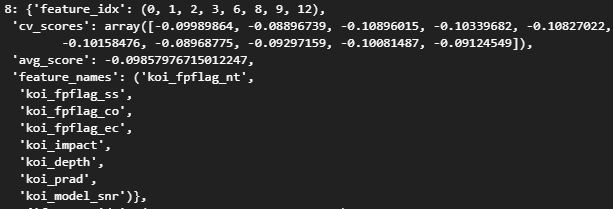

After extensive testing it has been revealed that reducing the features does significantly change the f1 scores of the models. Therefore the models are ran on all features
- feature evaluation used: correlation matrices,plot of the coefficients, and sequential feature analysis (uses mlxtend library) 
- Features with importance close to 0 have minimal impact 
- Removing features with a score <1 actually decreased the f1 scores
- PCA not used aid understandability and we do not have a large number of features

In [ ]:
keplerProcessed_df.info()

# <span style="color:slateblue"><b>Visualizations

In [ ]:
FOV_plot = px.scatter(keplerRAW_df,
                  x="ra", 
                  y="dec", 
                  color = "koi_disposition",
                  labels={
                     "ra": "Right Ascension",
                     "dec": "Declination",
                  },
                  template="plotly_dark",
                  width=1000, height=800
                 )
FOV_plot.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 35,
        dtick = 2
    )
)
#FOV_plot.add_trace(go.Scatter(y=[None], mode='markers',
#                         marker=dict(symbol='circle', color='blue'),

#                         ))
#FOV_plot.add_trace(go.Scatter(y=[None], mode='markers',
#                         marker=dict(symbol='circle', color='green'),

#                         ))

FOV_plot.show()

# ******Gabe suggestion - add density plots? to highlighting why each area may be more dense

# <span style="color:red"><b> Sequential Feature Selection results

### True

### FALSE

### using disposition instead of pdisposition